# Discrete Distribution Sampling
## Comparison of Different Sampling Methods

In [2]:
from ising_sampling import IsingSampler
import matplotlib.pyplot as plt

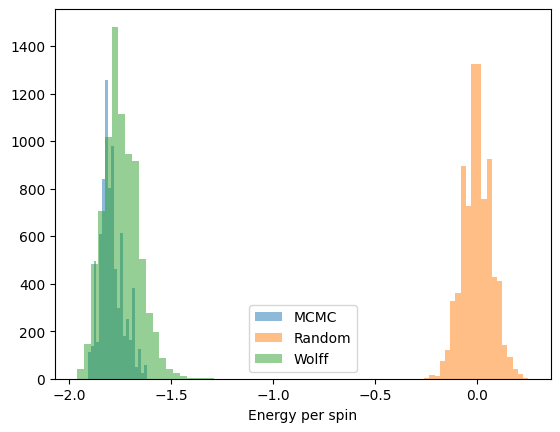

In [ ]:
from ising_sampling import IsingSampler
import matplotlib.pyplot as plt

# Set Ising model lattice size L
L = 20
# Temperature T and number of steps nsteps; nsteps is the number of MCMC iterations (updates)
T = 2.0
nsteps = L * L * 100
# Use MCMC Metropolis method for Ising model sampling
sampler = IsingSampler(L, T, nsteps)
states_mcmc, E_mcmc, M_mcmc = sampler.mcmc_metropolis()

# Use random sampling method for Ising model sampling
sampler = IsingSampler(L, T, nsteps)
states_rand, E_rand, M_rand = sampler.random_sampling()

# Use Wolff cluster method for Ising model sampling
sampler = IsingSampler(L, T, nsteps)
states_wolff, E_wolff, M_wolff = sampler.wolff_cluster()


# It is recommended to discard the first 80% of samples to avoid autocorrelation effects (i.e., use only equilibrium samples)
discard = int(nsteps * 0.8)
plt.hist(E_mcmc[discard:]/L**2, bins=20, alpha=0.5, label='MCMC')
plt.hist(E_rand[discard:]/L**2, bins=20, alpha=0.5, label='Random')
plt.hist(E_wolff[discard:]/L**2, bins=20, alpha=0.5, label='Wolff')
plt.xlabel('Energy per spin')
plt.legend()
plt.show()


MCMC ~ Boltzmann Distribution $P(E) \propto g(E) e^{-E/(k_BT)}$

MPS (here, actually just random 2D configurations, not true tensor network marginal distribution):

If you use random ±1 configurations, the energy distribution will be biased toward high energy (disordered), unlike MCMC/Wolff which concentrate in the low-energy region.

True tensor network sampling (e.g., exact 1D MPS sampling) would match the Boltzmann distribution, but this is just an illustration.

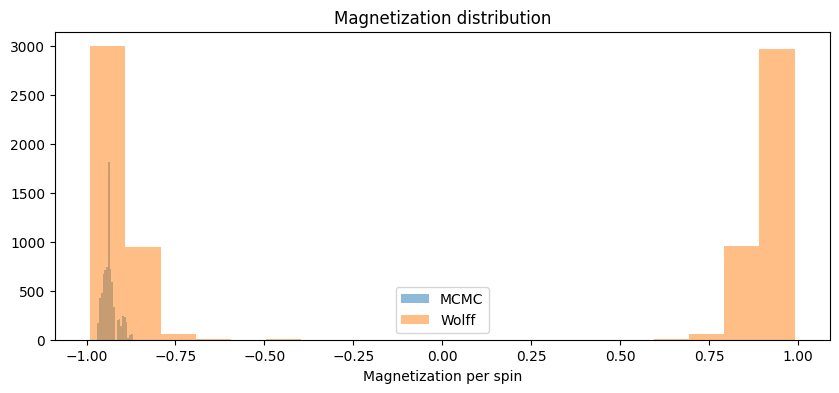

In [10]:
plt.figure(figsize=(10,4))
plt.hist(M_mcmc[discard:]/L**2, bins=20, alpha=0.5, label='MCMC')
plt.hist(M_wolff[discard:]/L**2, bins=20, alpha=0.5, label='Wolff')
plt.xlabel('Magnetization per spin')
plt.legend()
plt.title('Magnetization distribution')
plt.show()

In [11]:
import numpy as np

def heat_capacity(E, T, N):
    E = np.array(E)
    return (np.var(E) / (T**2 * N))

def susceptibility(M, T, N):
    M = np.array(M)
    return (np.var(M) / (T * N))

C_mcmc = heat_capacity(E_mcmc[discard:], T, L*L)
chi_mcmc = susceptibility(M_mcmc[discard:], T, L*L)
C_wolff = heat_capacity(E_wolff[discard:], T, L*L)
chi_wolff = susceptibility(M_wolff[discard:], T, L*L)

print(f"MCMC heat capacity C ≈ {C_mcmc:.3f}, susceptibility χ ≈ {chi_mcmc:.3f}")
print(f"Wolff heat capacity C ≈ {C_wolff:.3f}, susceptibility χ ≈ {chi_wolff:.3f}")

MCMC heat capacity C ≈ 0.318, susceptibility χ ≈ 0.083
Wolff heat capacity C ≈ 0.712, susceptibility χ ≈ 166.564


Use a trace plot to check thermalization, i.e., plot the energy as a function of step to see if the system has reached a stable (equilibrium) region.

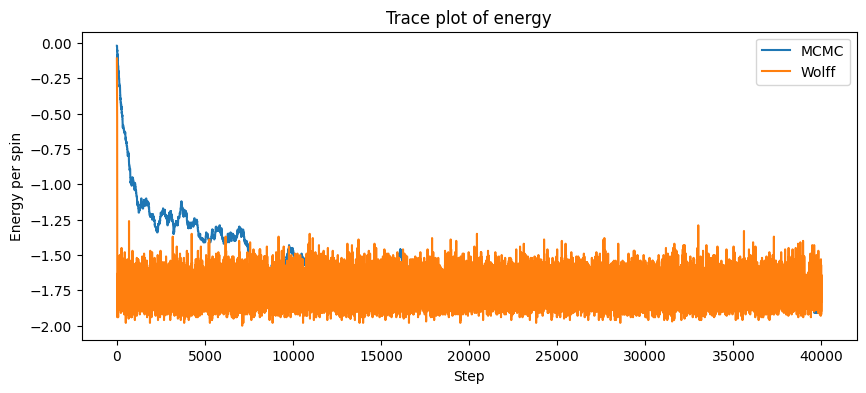

In [12]:
plt.figure(figsize=(10,4))
plt.plot(E_mcmc/L**2, label='MCMC')
plt.plot(E_wolff/L**2, label='Wolff')
plt.xlabel('Step')
plt.ylabel('Energy per spin')
plt.title('Trace plot of energy')
plt.legend()
plt.show()

## Autocorrelation Time

A statistical concept used to measure the correlation between samples in a sequence.

The autocorrelation function describes the correlation of a sequence $x_t$ at different time lags $\tau$: $$ C(\tau) = \frac{\langle (x_t - \langle x \rangle)(x_{t+\tau} - \langle x \rangle) \rangle}{\langle (x_t - \langle x \rangle)^2 \rangle} $$

The integrated autocorrelation time $\tau_{\text{int}}$ is the sum of the autocorrelation function: $$ \tau_{\text{int}} = 1 + 2 \sum_{\tau=1}^{\infty} C(\tau) $$

It measures the "independence" of samples: larger $\tau_{\text{int}}$ means samples are more correlated and fewer truly independent samples are available.

It tells you: "On average, how many steps apart do you need to sample for the samples to be independent."

In MCMC or physical simulations, the autocorrelation time reflects the timescale over which the system remembers its state.

If $\tau_{\text{int}}$ is large, the system takes a long time to "forget" its initial state, samples are highly correlated, and statistical errors are large.

If $\tau_{\text{int}}$ is small, samples decorrelate quickly and statistical efficiency is high.

Metropolis 能量自相關時間 ≈ 815.4 步
Wolff 能量自相關時間 ≈ 11.9 步


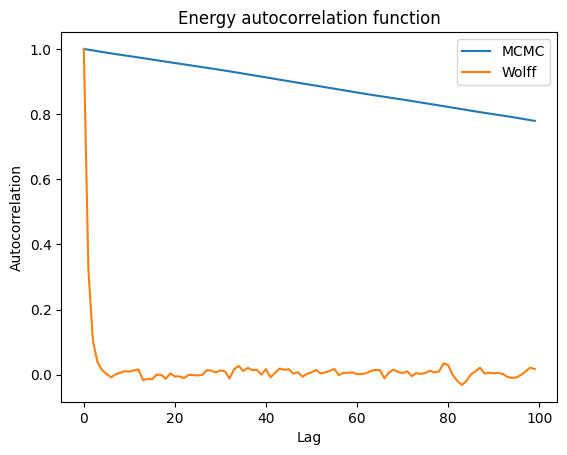

In [13]:
import numpy as np

def autocorr_time(x, max_lag=1000):
    x = np.asarray(x)
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    acf = result[result.size // 2:] / result[result.size // 2]
    # 積分自相關函數直到第一次為負
    tau = 1 + 2 * np.sum(acf[1:max_lag][acf[1:max_lag]>0])
    return tau, acf[:100]

tau_E, acf_E = autocorr_time(E_mcmc[int(nsteps*0.8):])
print(f"Metropolis 能量自相關時間 ≈ {tau_E:.1f} 步")
tau_Ew, acf_Ew = autocorr_time(E_wolff[int(nsteps*0.8):])
print(f"Wolff 能量自相關時間 ≈ {tau_Ew:.1f} 步")

plt.plot(acf_E, label='MCMC')
plt.plot(acf_Ew, label='Wolff')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Energy autocorrelation function')
plt.legend()
plt.show()

In MCMC, the autocorrelation typically decays more slowly than in the Wolff algorithm, indicating stronger correlations between MCMC samples. Wolff samples decorrelate more quickly.

Near the critical point, $\tau_{\text{int}}$ increases dramatically due to critical slowing down, which is why cluster algorithms (like Wolff) outperform single-site Metropolis updates.

The number of effectively independent samples is approximately $N_{\text{eff}} \approx N_{\text{total}} / (2\tau_{\text{int}})$

If you're estimating the mean and error of a physical observable, you must account for the autocorrelation time—otherwise, the error will be underestimated.

# Critical Phenomena

Observe the changes in energy and magnetization distributions of the 2D Ising model at different temperatures (especially near the critical point $T_c \approx 2.269$) to visually demonstrate the multi-peak and flat features at the critical point.

1. Sample at different temperatures
It is recommended to use Wolff or MCMC methods to sample at $T < T_c$, $T \approx T_c$, and $T > T_c$.

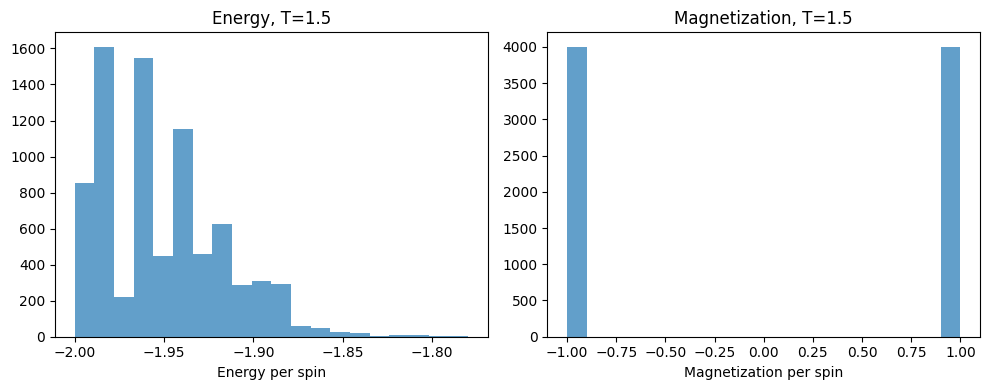

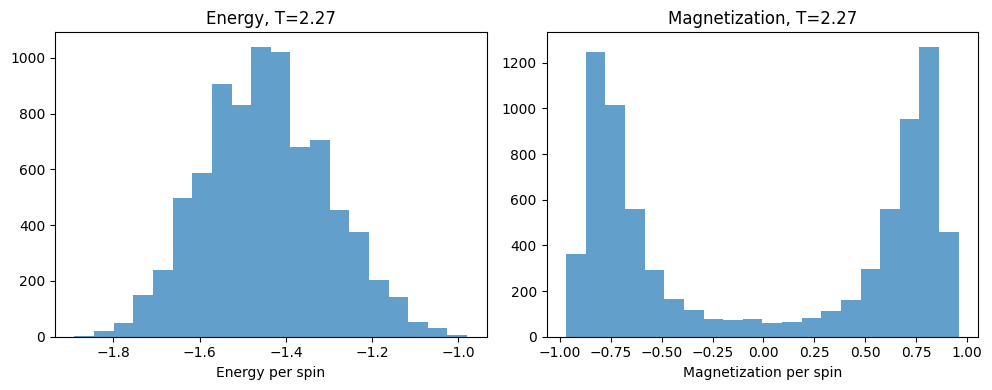

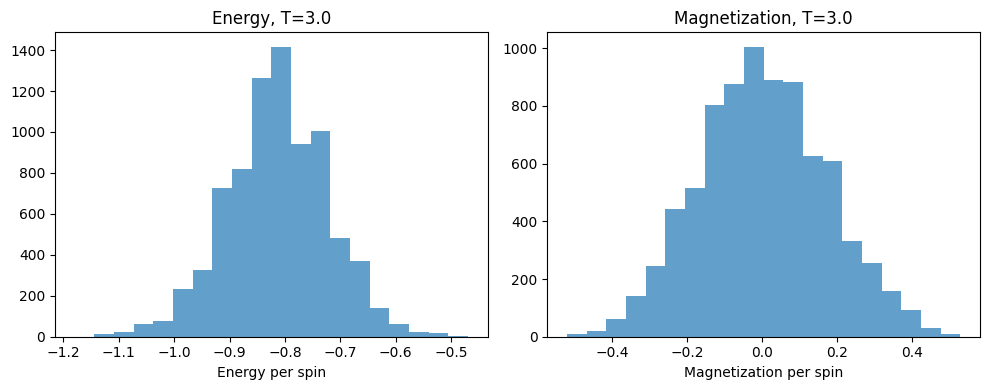

In [14]:
L = 20
nsteps = L * L * 100
temps = [1.5, 2.27, 3.0]  # 低溫、臨界、和高溫

for T in temps:
    sampler = IsingSampler(L, T, nsteps)
    _, E, M = sampler.wolff_cluster()
    discard = int(nsteps * 0.8)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(E[discard:]/L**2, bins=20, alpha=0.7)
    plt.xlabel('Energy per spin')
    plt.title(f'Energy, T={T}')
    plt.subplot(1,2,2)
    plt.hist(M[discard:]/L**2, bins=20, alpha=0.7)
    plt.xlabel('Magnetization per spin')
    plt.title(f'Magnetization, T={T}')
    plt.tight_layout()
    plt.show()

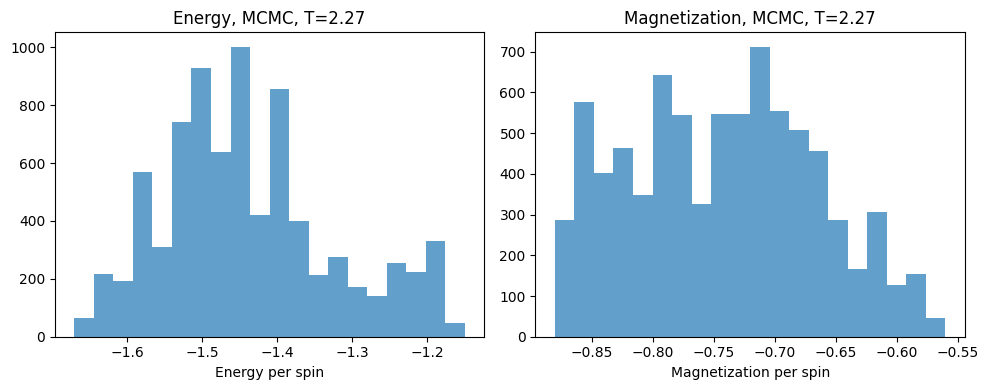

In [15]:
L = 20
nsteps = L * L * 100
T = 2.27  # 臨界點
sampler = IsingSampler(L, T, nsteps)
_, E_mcmc, M_mcmc = sampler.mcmc_metropolis()
discard = int(nsteps * 0.8)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(E_mcmc[discard:]/L**2, bins=20, alpha=0.7)
plt.xlabel('Energy per spin')
plt.title('Energy, MCMC, T=2.27')
plt.subplot(1,2,2)
plt.hist(M_mcmc[discard:]/L**2, bins=20, alpha=0.7)
plt.xlabel('Magnetization per spin')
plt.title('Magnetization, MCMC, T=2.27')
plt.tight_layout()
plt.show()

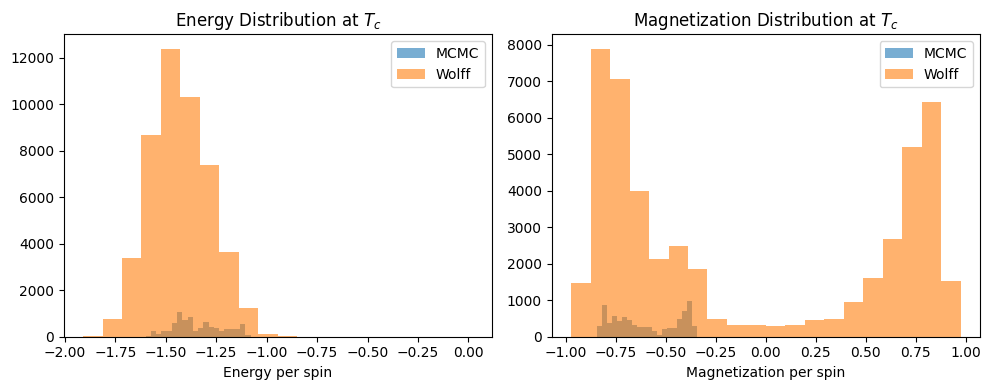

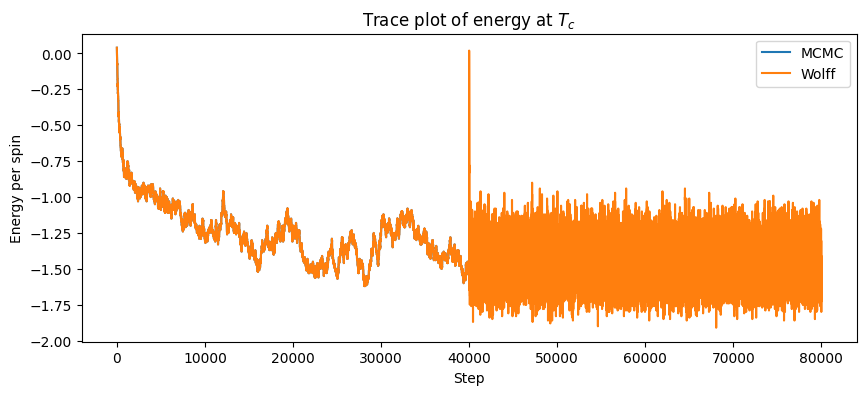

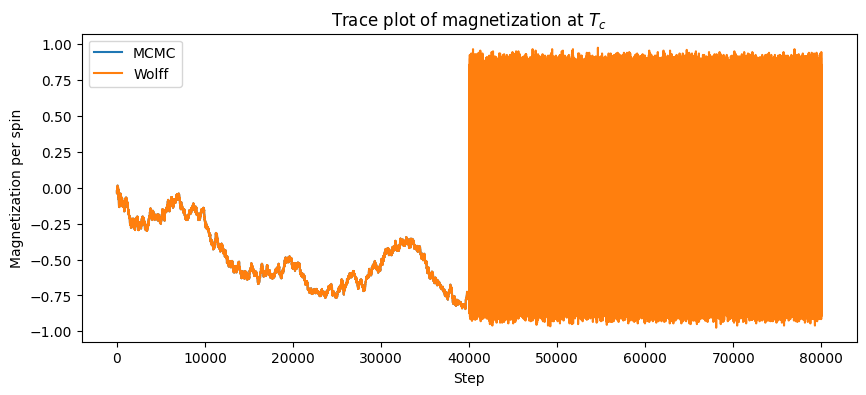

In [16]:
L = 20
nsteps = L * L * 100
T = 2.27  # 臨界點
discard = int(nsteps * 0.8)

sampler = IsingSampler(L, T, nsteps)
_, E_mcmc, M_mcmc = sampler.mcmc_metropolis()
_, E_wolff, M_wolff = sampler.wolff_cluster()

# 能量分布比較
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(E_mcmc[discard:]/L**2, bins=20, alpha=0.6, label='MCMC')
plt.hist(E_wolff[discard:]/L**2, bins=20, alpha=0.6, label='Wolff')
plt.xlabel('Energy per spin')
plt.title('Energy Distribution at $T_c$')
plt.legend()

# 磁化量分布比較
plt.subplot(1,2,2)
plt.hist(M_mcmc[discard:]/L**2, bins=20, alpha=0.6, label='MCMC')
plt.hist(M_wolff[discard:]/L**2, bins=20, alpha=0.6, label='Wolff')
plt.xlabel('Magnetization per spin')
plt.title('Magnetization Distribution at $T_c$')
plt.legend()
plt.tight_layout()
plt.show()

# 能量 trace plot
plt.figure(figsize=(10,4))
plt.plot(E_mcmc/L**2, label='MCMC')
plt.plot(E_wolff/L**2, label='Wolff')
plt.xlabel('Step')
plt.ylabel('Energy per spin')
plt.title('Trace plot of energy at $T_c$')
plt.legend()
plt.show()

# 磁化量 trace plot
plt.figure(figsize=(10,4))
plt.plot(M_mcmc/L**2, label='MCMC')
plt.plot(M_wolff/L**2, label='Wolff')
plt.xlabel('Step')
plt.ylabel('Magnetization per spin')
plt.title('Trace plot of magnetization at $T_c$')
plt.legend()
plt.show()

## Tensor Network Sampling and Quantum Information

**Main Idea**

Classical models: Use tensor networks to represent the partition function and probability distributions of models such as Ising and Potts, enabling efficient sampling.

Quantum systems: Use tensor networks to approximate high-dimensional quantum states, allowing for quantum Monte Carlo sampling or simulation of quantum measurements.

Advantages: Capable of handling systems with exponential dimensionality, capturing long-range entanglement and critical behavior, and directly interfacing with quantum computation.

**Connection to Quantum Computing**

Tensor networks form the theoretical foundation for quantum computer simulations and variational quantum algorithms (such as VQE, QAOA).

Quantum Monte Carlo, quantum random walks, and other quantum sampling methods can also be analyzed and accelerated using tensor networks.

# Continuous Distribution Sampling

In physical problems such as the Ising model, sampling is usually discrete (e.g., $\pm1$).

However, in modern machine learning (especially generative models, quantum information, Bayesian learning), many latent variables/parameters/spaces are continuous, for example:

- The latent space of VAE/GAN is usually Gaussian (continuous).
- Parameters, measurement results, and noise in quantum states are often modeled with continuous distributions.
- The posterior distribution of parameters in Bayesian neural networks is usually continuous.

> If you want your model to "generate" new data, explore continuous physical/quantum state spaces, or perform parameter uncertainty analysis,
you must be able to sample from continuous distributions.

# Reparameterization

Problem: Why can't we just sample directly?

In models like VAE, the encoder outputs a distribution (e.g., $q(z|x)$), and we want to sample latent $z$ from this distribution, then use the decoder to reconstruct $x$.

But if we directly use $z \sim N(\mu, \sigma^{2})$, this sampling step is not differentiable, so we can't train the neural network with backpropagation.

Solution: Reparameterization trick

Decompose the sampling into a "differentiable part" and a "random part":

$z = \mu + \sigma \cdot \epsilon$, where $\epsilon \sim N(0,1)$
$\mu, \sigma$ are outputs of the neural network, $\epsilon$ is random noise.

This way, $z$ is differentiable with respect to $\mu, \sigma$, so the whole model can be trained with gradient descent.

$\mu, \sigma$

$N(\mu, \sigma^2)$

In [ ]:
# 連續高斯分布 sampling
z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))

# VAE 重參數化技巧
mu, logvar = encoder(x)  # 神經網路輸出均值與對數方差
std = np.exp(0.5 * logvar)
eps = np.random.normal(size=std.shape)
z = mu + std * eps  # 這樣 z 對 mu, logvar 可微分